## **Phase 1: Understanding the Problem**

**Employee Burn Out**

Employee burnout is a work-related condition characterized by emotional exhaustion toward one’s job, and reduced professional effectiveness. It stems from prolonged workplace stress and can lead to lower productivity, increased absenteeism, higher turnover, and greater healthcare costs.

Toxic workplace cultures and poor work–life balance are strong contributors, while supportive leadership and healthy organizational practices can reduce its risk.

**Data Driven Approach**

Using **data-driven** approaches to predict and prevent burnout has become increasingly important. Machine learning models, workplace analytics, and even wearable technologies can identify early warning signs such as workload spikes, job stress, and cultural risk factors. Predictive models can assimulate possible burn outs among worker, it can also tell what impacts burn out give direction to where improvement can be made to reduce these burn out and increase productivity.

Organizations can leverage this data to implement targeted strategies—adjusting workloads, fostering better communication, and improving psychosocial safety climates. These approaches not only protect employee well-being but also deliver measurable business benefits by reducing absenteeism, improving retention, and sustaining long-term productivity.

## **Phase 2: Exploratory Data Analysis (EDA)**

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Importing dats using google link

missing_vals = ['unknown', '-', ' ']

import requests

def read_gd(sharing_url):
  """ Download a CSV file from Google Drive and returna Pandas DataFrame"""
  file_id = sharing_url.split('/')[-2] #Extracting file ID
  download_url = f"https://drive.google.com/uc?export=download&id=" + file_id

  url = requests.get(download_url).text
  csv_raw = StringIO(url)
  return csv_raw

url_test = "https://drive.google.com/file/d/1XsiwqEAkHeUF5yB83lvKeEw0uTun2-SA/view?usp=sharing" #Data where burnout will be predicted
url_train = "https://drive.google.com/file/d/1YsDvd5wjSAmeCQtMOQNZrGIxgU7GFzRU/view?usp=sharing" #Data to train the model
gdd = read_gd(url_test)
gdt = read_gd(url_train)

df_test = pd.read_csv(gdd, na_values = missing_vals)
df = pd.read_csv(gdt, na_values = missing_vals)

df_test.head() # For predition after the model has been created

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4


### **Data Overview**

In [3]:
#Remove spaces in column title and renaming column titles
col_names = [col.strip().lower().replace(' ', '_') for col in df.columns]
df.columns = col_names

In [4]:
#Rename column
df.rename(columns = {
    "date_of_joining": "start_date",
    "wfh_setup_available": "wfh", #WFH is work from home
    "resource_allocation": "work_hours",
    "mental_fatigue_score": "fatigue_score",}, inplace=True)

df.head()

,employee_id,start_date,gender,company_type,wfh,designation,work_hours,fatigue_score,burn_rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


###Checking for missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   employee_id    22750 non-null  object 
 1   start_date     22750 non-null  object 
 2   gender         22750 non-null  object 
 3   company_type   22750 non-null  object 
 4   wfh            22750 non-null  object 
 5   designation    22750 non-null  float64
 6   work_hours     21369 non-null  float64
 7   fatigue_score  20633 non-null  float64
 8   burn_rate      21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


Missing values are observed in columns, resource allocation, mental_fatique_score and burn rate

In [6]:
df.isnull().sum() / len(df) * 100

employee_id      0.000000
start_date       0.000000
gender           0.000000
company_type     0.000000
wfh              0.000000
designation      0.000000
work_hours       6.070330
fatigue_score    9.305495
burn_rate        4.940659
dtype: float64

About 6% of values are missing in resource allocation column,  9% in mental fatique score and 4% in burn rate. dropping the data may result in lossing upto 10% of the data which is not advisable. I recommend handling this missing vales by iteratively imputing.

In [7]:
#Import Inputer to fill in missing value
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Select column to apply imputation
imp_cols = ['work_hours', 'fatigue_score', 'burn_rate']

iterimp = IterativeImputer() #Initializing the Imputer

#Applying the Imputer
df[imp_cols] = pd.DataFrame(iterimp.fit_transform(df[imp_cols]),
                            columns=imp_cols,
                            index=df.index)
#Rounding work hours up and changing the datatype to integer
df['work_hours'] = df['work_hours'].round(0).astype(int)
df.head()

,employee_id,start_date,gender,company_type,wfh,designation,work_hours,fatigue_score,burn_rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,5,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7,6.9,0.52


The start date is not in datetime format. Use pandas to convert to a datetime format and create columns for month, day and year

In [8]:
#Convert start date to date format
df['start_date'] = pd.to_datetime(df['start_date'])

#Extracting Year, Day and Month from start date
df['Year'] = df['start_date'].dt.year.astype(str)
df['month'] = df['start_date'].dt.month_name()
df['day'] = df['start_date'].dt.day_name()

df.head()

,employee_id,start_date,gender,company_type,wfh,designation,work_hours,fatigue_score,burn_rate,Year,month,day
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3,3.8,0.16,2008,September,Tuesday
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2,5.0,0.36,2008,November,Sunday
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,5,5.8,0.49,2008,March,Monday
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1,2.6,0.20,2008,November,Monday
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7,6.9,0.52,2008,July,Thursday


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   employee_id    22750 non-null  object        
 1   start_date     22750 non-null  datetime64[ns]
 2   gender         22750 non-null  object        
 3   company_type   22750 non-null  object        
 4   wfh            22750 non-null  object        
 5   designation    22750 non-null  float64       
 6   work_hours     22750 non-null  int32         
 7   fatigue_score  22750 non-null  float64       
 8   burn_rate      22750 non-null  float64       
 9   Year           22750 non-null  object        
 10  month          22750 non-null  object        
 11  day            22750 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), object(7)
memory usage: 2.0+ MB


In [10]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,22750,2008-07-01 09:28:05.274725120,2008-01-01 00:00:00,2008-04-01 00:00:00,2008-07-02 00:00:00,2008-09-30 00:00:00,2008-12-31 00:00:00,NaN
designation,22750.0,2.178725,0.0,1.0,2.0,3.0,5.0,1.135145
work_hours,22750.0,4.479912,0.0,3.0,4.0,6.0,10.0,2.030671
fatigue_score,22750.0,5.728864,0.0,4.5,5.9,7.1,10.827763,1.912851
burn_rate,22750.0,0.451856,-0.11123,0.32,0.45,0.59,1.0,0.197671


##Checking for Outliers

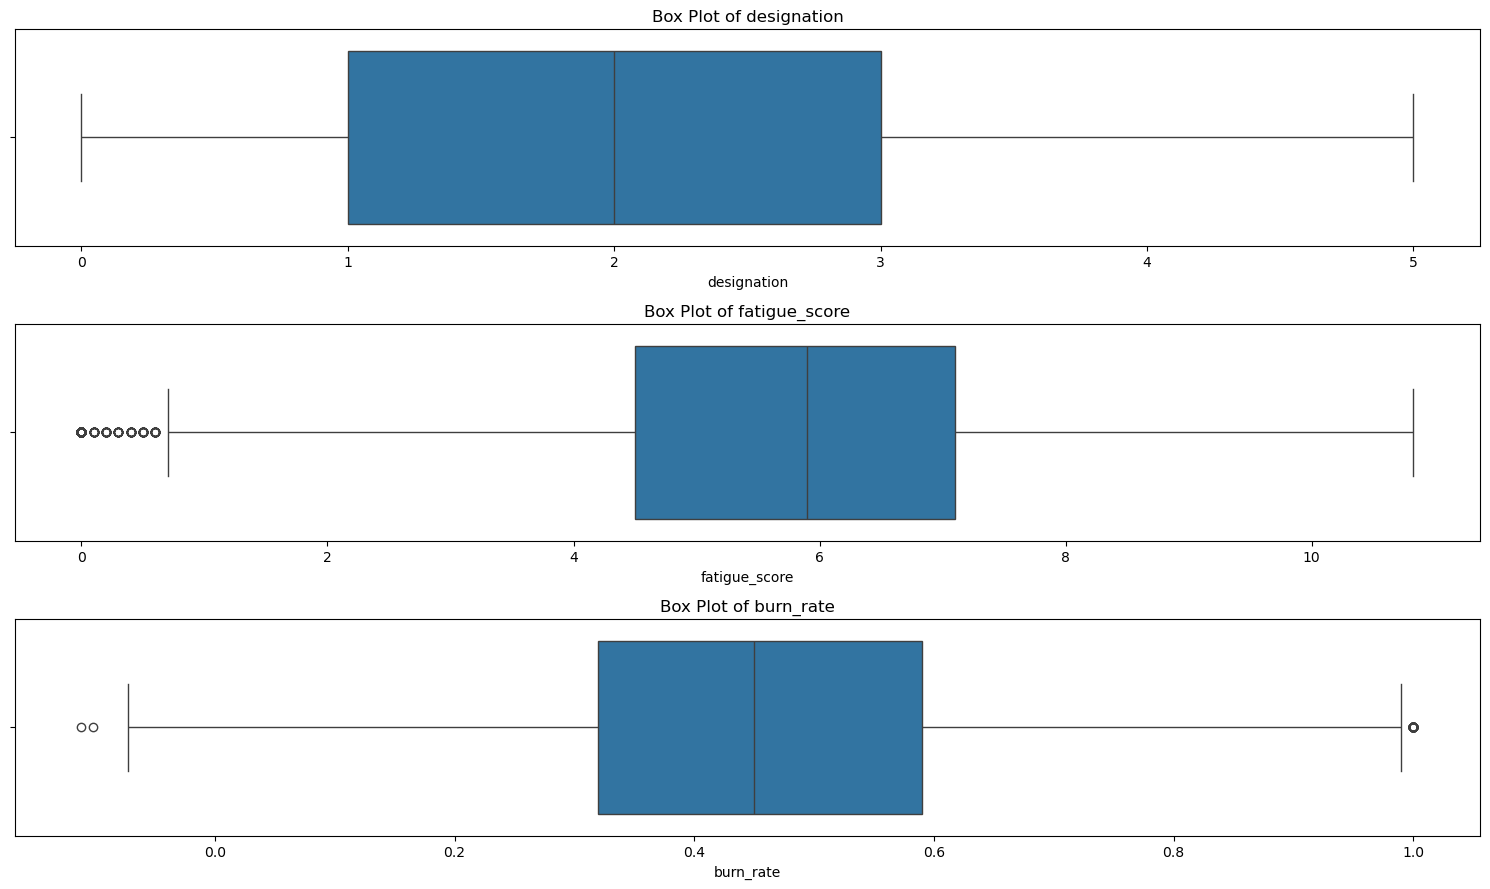

In [11]:
#Filter numerical columns to check outliers
num_feat = df.select_dtypes(include=['float64', 'int64']).columns

#Create box plot numerical features
plt.figure(figsize=(15, len(num_feat)*3)) #Adjust the size of the figures

for i, col in enumerate(num_feat, 1):
  plt.subplot(len(num_feat), 1, i)
  sns.boxplot(x=df[col])
  plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()


The Plot above show that this dataset doesnt have the presence of outliers. As such, further analysis can continue

**Univariate Analysis**

Having a descriptive analysis for categorical columns

In [12]:
#Separating data into numerical and categorical columns
cat_df = df.select_dtypes(include=['object']).drop('employee_id', axis=1) #Dropping employee id from categorical columns
num_df = df.select_dtypes(include=['float64', 'int64'])

In [13]:
def uni_anal(categorical_df):

  for col_name in categorical_df:
    print("*"*10, col_name, "*"*10)
    print(categorical_df[col_name].value_counts(ascending=False))
    print()

uni_anal(cat_df)

********** gender **********
gender
Female    11908
Male      10842
Name: count, dtype: int64

********** company_type **********
company_type
Service    14833
Product     7917
Name: count, dtype: int64

********** wfh **********
wfh
Yes    12290
No     10460
Name: count, dtype: int64

********** Year **********
Year
2008    22750
Name: count, dtype: int64

********** month **********
month
August       1972
October      1970
September    1968
March        1947
July         1911
January      1903
May          1900
April        1861
December     1844
November     1841
February     1832
June         1801
Name: count, dtype: int64

********** day **********
day
Tuesday      3369
Wednesday    3341
Monday       3290
Sunday       3228
Saturday     3213
Thursday     3190
Friday       3119
Name: count, dtype: int64



Text(0.5, 1.0, 'Pie chart of Work from Home')

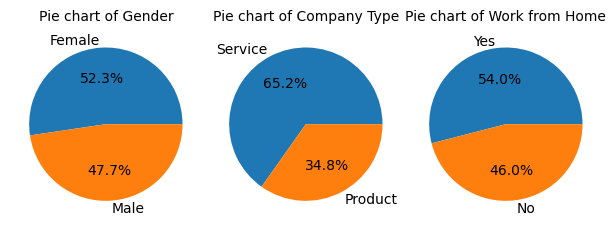

In [14]:
#Plot the pie chart of the gender, company type, and whether there is availability for them to work from home
fig, axs = plt.subplots(1,3, figsize=(6,3), layout ='constrained')
pie_data = df['gender'].value_counts(normalize=True)
axs[0].pie(pie_data.values, labels = pie_data.index, autopct='%1.1f%%')
axs[0].set_title('Pie chart of Gender', fontsize='medium')

pie_data = df['company_type'].value_counts(normalize=True)
axs[1].pie(pie_data.values, labels = pie_data.index, autopct='%1.1f%%')
axs[1].set_title('Pie chart of Company Type', fontsize='medium')

pie_data = df['wfh'].value_counts(normalize=True)
axs[2].pie(pie_data.values, labels = pie_data.index, autopct='%1.1f%%')
axs[2].set_title('Pie chart of Work from Home', fontsize='medium')

The dataset has more women with 52.3% being women and 47.7% men and the largest percentage is from the service company having 65.2% and the product company, 34.8%. 54% have the option of working from home available while 46% do not.

In [15]:
df.describe()

,start_date,designation,work_hours,fatigue_score,burn_rate
count,22750,22750.000000,22750.000000,22750.000000,22750.000000
mean,2008-07-01 09:28:05.274725120,2.178725,4.479912,5.728864,0.451856
min,2008-01-01 00:00:00,0.000000,0.000000,0.000000,-0.111230
25%,2008-04-01 00:00:00,1.000000,3.000000,4.500000,0.320000
50%,2008-07-02 00:00:00,2.000000,4.000000,5.900000,0.450000
75%,2008-09-30 00:00:00,3.000000,6.000000,7.100000,0.590000
max,2008-12-31 00:00:00,5.000000,10.000000,10.827763,1.000000
std,NaN,1.135145,2.030671,1.912851,0.197671


The average work hours for these data set is 4.48 hours with standard deviation of 2. The mean fatigue score is 5.7 with a standard deviation of approximately 2. the mean burn rate amongst these sample is 0.45.

**Distribution of the data**

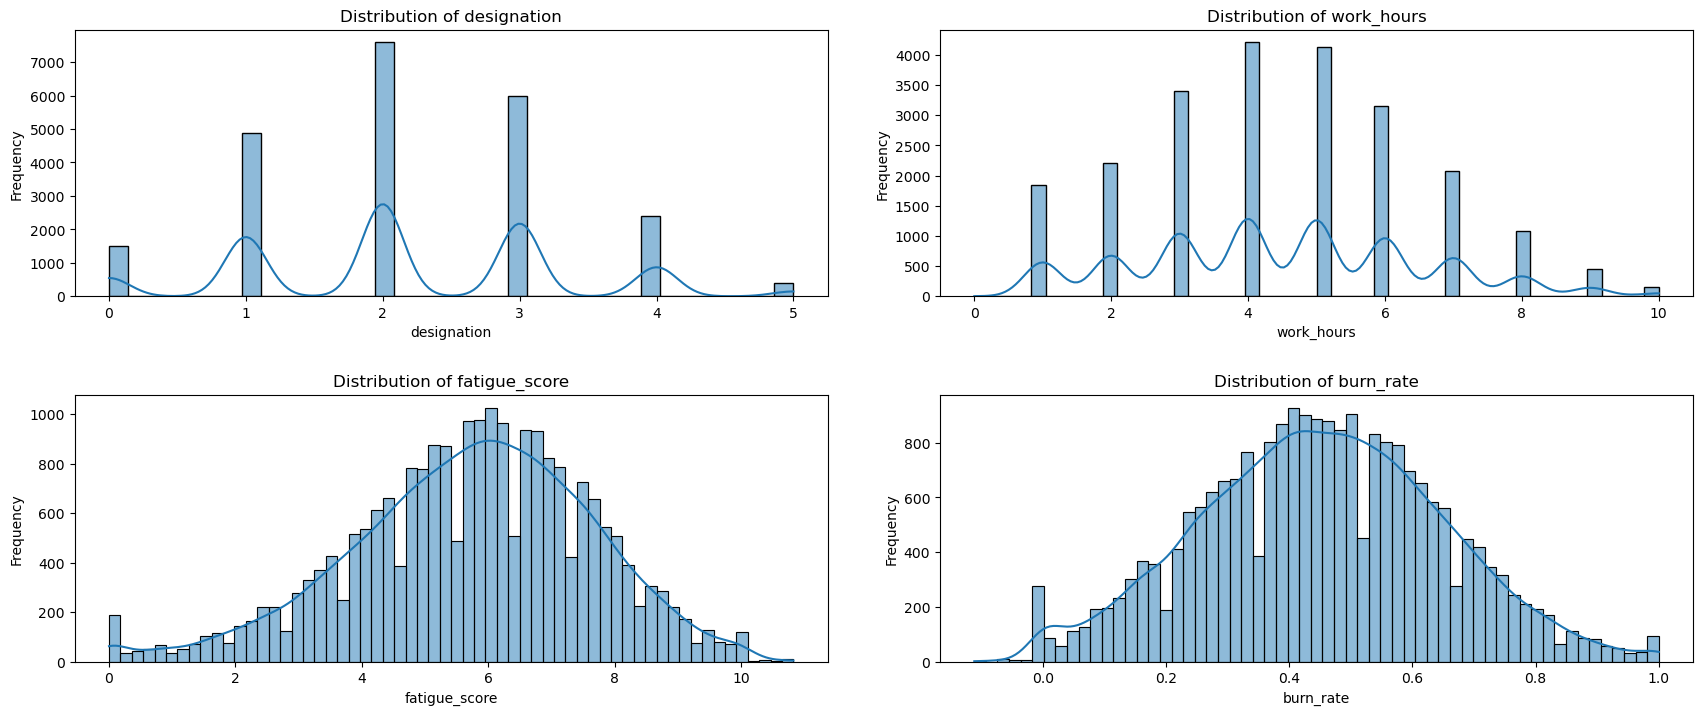

In [16]:
def uni_analysis(numerical_df):
  num_col = ['designation', 'work_hours', 'fatigue_score', 'burn_rate']
  ncols = 2
  nrows = (len(num_col) + ncols -1) // ncols
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4* nrows))
  fig.tight_layout(pad=5.0)

  axs = axs.flatten()

  for i, col_name in enumerate(num_col):
    sns.histplot(data=df, x=col_name, kde=True, ax=axs[i]) #Use KDE to smoothen the distribution curve
    axs[i].set_title(f"Distribution of {col_name}")
    axs[i].set_ylabel("Frequency")
    axs[i].set_xlabel(col_name)

  #Remove any unused subplots if the number of numericcal columns is not a multiple of 2
  for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

  plt.show()
uni_analysis(df)

The data shows a normal distribution with little to no skewness

**Bivariate Analysis**

**1. Check the trend in burn rate across months in 2018 amongst workers.**

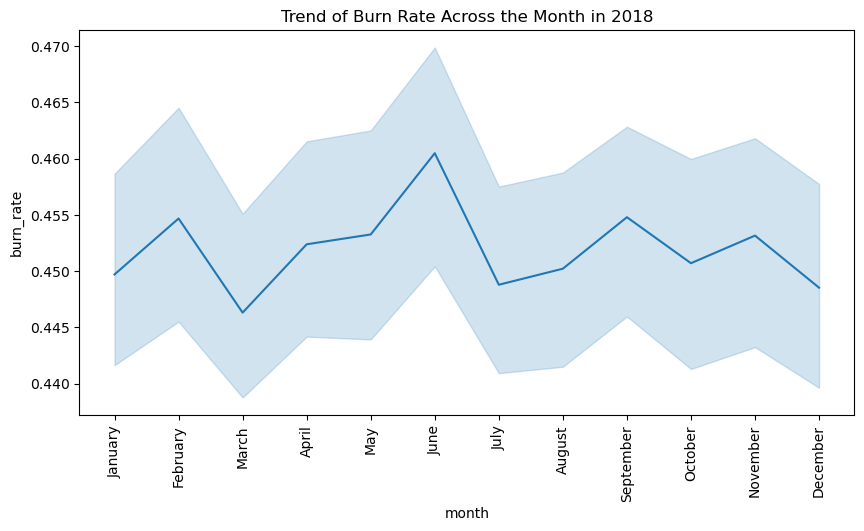

In [17]:
import calendar #Import calendar to help order month

#Ordering the month according to the calendar
month_name = list(calendar.month_name)[1:]
df['month'] = pd.Categorical(df['month'], categories=month_name, ordered=True)

#Plot line graph for trend
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='month', y='burn_rate', data=df, ax=ax)
plt.title('Trend of Burn Rate Across the Month in 2018')
plt.xticks(rotation=90) #Rotate the month naming on the x axis to prevent overlapping
plt.show()

The line plot above shows that June recorded the highest burn rate within the year 2018 amongst workers.

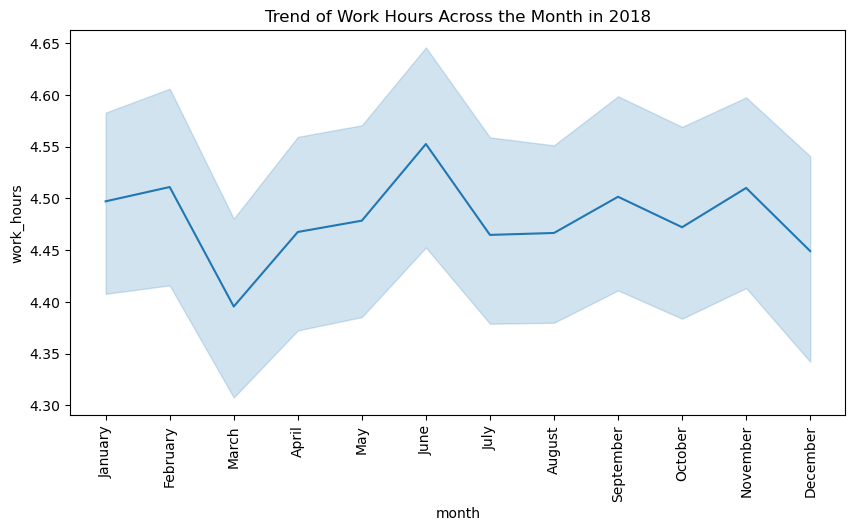

In [18]:
#Ordering the month according to the calendar
month_name = list(calendar.month_name)[1:]
df['month'] = pd.Categorical(df['month'], categories=month_name, ordered=True)

#Plot line graph for trend
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='month', y='work_hours', data=df, ax=ax)
plt.title('Trend of Work Hours Across the Month in 2018')
plt.xticks(rotation=90) #Rotate the month naming on the x axis to prevent overlapping
plt.show()

The line plot above shows that June recorded the highest work hours within the year 2018 amongst workers.

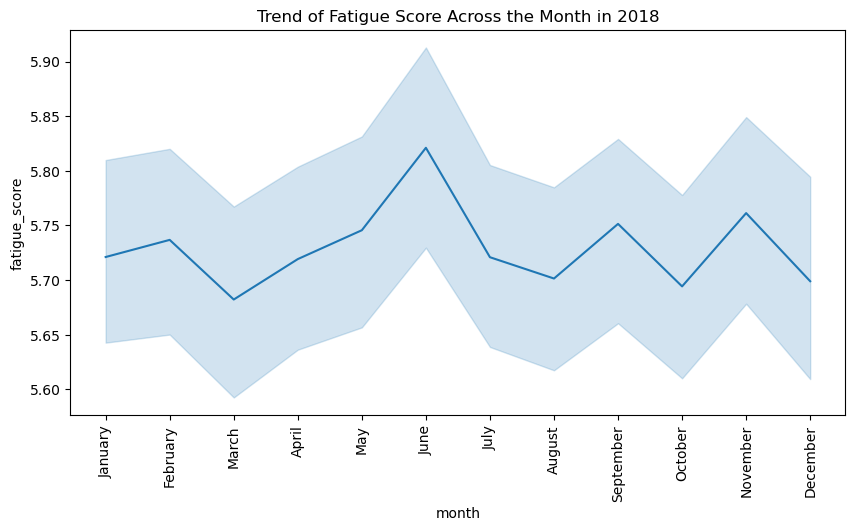

In [19]:
#Ordering the month according to the calendar
month_name = list(calendar.month_name)[1:]
df['month'] = pd.Categorical(df['month'], categories=month_name, ordered=True)

#Plot line graph for trend
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='month', y='fatigue_score', data=df, ax=ax)
plt.title('Trend of Fatigue Score Across the Month in 2018')
plt.xticks(rotation=90) #Rotate the month naming on the x axis to prevent overlapping
plt.show()

The line plot above shows that June recorded the highest fatigue score within the year 2018 amongst workers.

**2. Does Designation, Work Hours, and Fatigue Score have impact on Burn Rate**

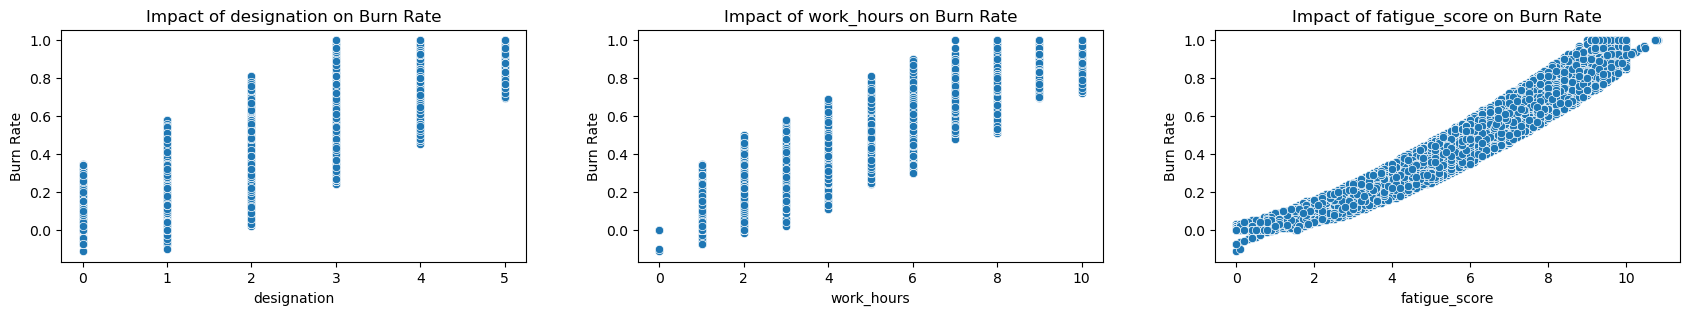

In [20]:
def biv_analy(numerical_df):
  num_col = ['designation', 'work_hours', 'fatigue_score']
  ncols = 3
  nrows = (len(num_col) + ncols -1) // ncols
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4* nrows))
  fig.tight_layout(pad=5.0)

  axs = axs.flatten()

  for i, col_name in enumerate(num_col):
    sns.scatterplot(data=numerical_df, x=col_name, y='burn_rate', ax=axs[i]) #Plot scatter plot to check relationships
    axs[i].set_title(f"Impact of {col_name} on Burn Rate")
    axs[i].set_ylabel("Burn Rate")
    axs[i].set_xlabel(col_name)

# Remove any unused subplots if the number of numerical columns is not a multiple of 3
  for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
  plt.show()

biv_analy(df)

The scatter plot above shows a great relationship between the burn rate with designation, work hours and fatigue score

Going a step further to check the correlation between these variable and the burn rate

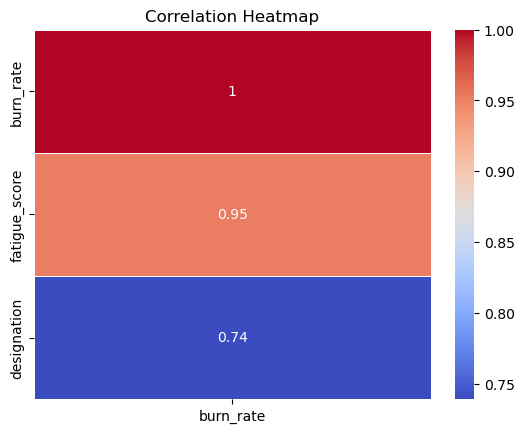

In [21]:
#Plot a heat map to observe correlation values
sns.heatmap(num_df.corr()[['burn_rate']].sort_values(by='burn_rate', ascending=False),
            annot=True, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Heatmap')
plt.yticks(rotation=90)

plt.show()

The correlation heatmap further emphasize the strong impact that fatigue score, work hour, and designation has burn rate. Fatigue score has the highest impact of up to 95%

**3. Does Gender, Company Type and Working from Home impact Burn rate in workers**

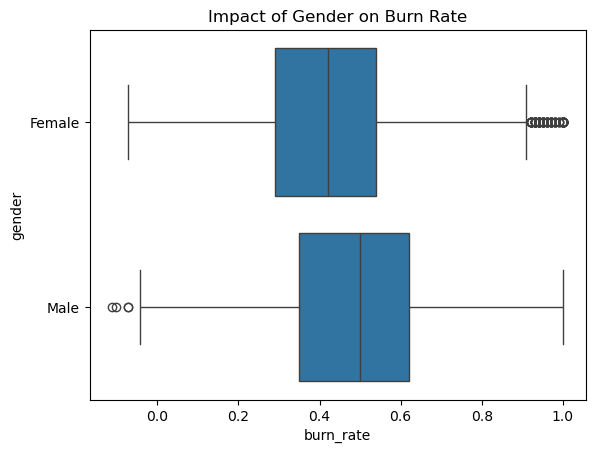

In [22]:
sns.boxplot(y='gender', x='burn_rate', data=df)
plt.title('Impact of Gender on Burn Rate')
plt.show()

The box plot above showing the relationship of gender with burn rate, it shows that males have slightly more burn rate than female

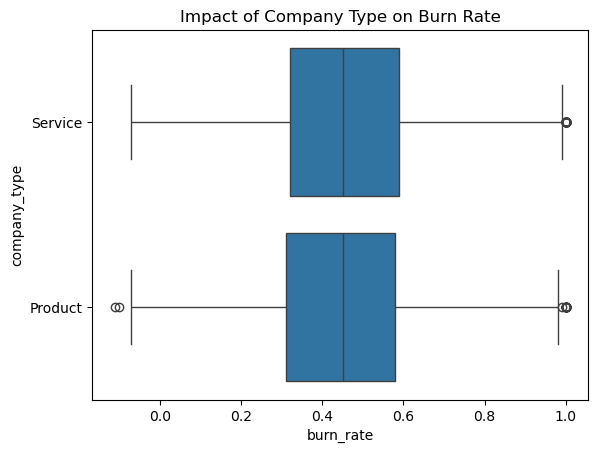

In [23]:
sns.boxplot(y='company_type', x='burn_rate', data=df)
plt.title('Impact of Company Type on Burn Rate')
plt.show()

The box plot above shows the relationship of company type with burn rate; it shows no impact on burn rate by company type

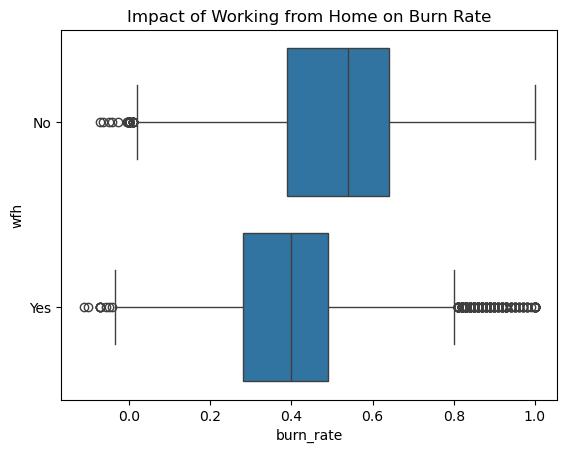

In [24]:
sns.boxplot(y='wfh', x='burn_rate', data=df)
plt.title('Impact of Working from Home on Burn Rate')
plt.show()

The box plot above showing the relationship of working from home with burnout rate; it shows that workers who do not work from home experience a higher burnout rate than those who work from home.

To further understand the how much impact working from home and gender on the burn rate. Carry out an ANOVA testing.

In [25]:
from scipy.stats import f_oneway #Import library for ANOVA testing

def anova_cat(categorical_df, significant_level, target_var='burn_rate'):
  cat_col = ['gender', 'wfh', 'company_type']

  for col_name in cat_col:
    groups = [categorical_df[categorical_df[col_name] == cat][target_var]
              for cat in categorical_df[col_name].unique()] #Grouping the categorical columns
    stat, p_val = f_oneway(*groups)
    if p_val < significant_level:
      impact = 'significant impact on Burn rate'
    else:
      impact = 'no significant impact on Burn rate'
    print("*"*5, col_name, "*"*5)
    print(f" F={stat:.3f}, p={p_val:.3f}  ----  {col_name} has {impact}\n") #Add newline

anova_cat(df, significant_level=0.05)

***** gender *****
 F=560.051, p=0.000  ----  gender has significant impact on Burn rate

***** wfh *****
 F=2335.908, p=0.000  ----  wfh has significant impact on Burn rate

***** company_type *****
 F=0.255, p=0.613  ----  company_type has no significant impact on Burn rate



The ANOVA test shows that gender and working from home has significant impact on the burn rate of works

## **Phase 3 & 4: Data Preprocessing and Model Development**

**Machine Learning Model**

Applying encodeing to categorical columns as preparation for machine learning model creation


And Normalizing some columns for ML model

In [26]:
df.head()

,employee_id,start_date,gender,company_type,wfh,designation,work_hours,fatigue_score,burn_rate,Year,month,day
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3,3.8,0.16,2008,September,Tuesday
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2,5.0,0.36,2008,November,Sunday
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,5,5.8,0.49,2008,March,Monday
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1,2.6,0.20,2008,November,Monday
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7,6.9,0.52,2008,July,Thursday


In [27]:
#defining the ordering for categorical columns - lowest to highest

df_enc = df[['gender', 'company_type', 'wfh']] #Select categorical columns to encode


company_cat = ['Service', 'Product']
gender_cat = ['Male', 'Female']
wfh_cat = ['Yes', 'No']

# creating the ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories = [gender_cat, company_cat, wfh_cat],
                                handle_unknown='use_encoded_value',
                                unknown_value=-1,
                                )
                        

#applying the encoder
df_enc_cat = pd.DataFrame(encoder.fit_transform(df_enc),
                                columns=encoder.get_feature_names_out(),
                                index = df_enc.index)
df_enc_cat

,gender,company_type,wfh
0,1.0,0.0,1.0
1,0.0,0.0,0.0
2,1.0,1.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,1.0
...,...,...,...
22745,1.0,0.0,1.0
22746,1.0,1.0,0.0
22747,0.0,0.0,0.0
22748,1.0,0.0,1.0


In [29]:
#Importing the required library
from sklearn.preprocessing import MinMaxScaler

#Create MinMaxScaler instance
scaler = MinMaxScaler()

#Apply normalization
norm_df = pd.DataFrame(scaler.fit_transform(df[['designation', 'work_hours', 'fatigue_score']]))

#Rename the column
norm_df.columns = ['designation', 'work_hours', 'fatigue_score']

#Add normalized data to the data frame
df_norm = pd.concat([df_enc_cat, norm_df], axis=1)


df_norm.head()

,gender,company_type,wfh,designation,work_hours,fatigue_score
0,1.0,0.0,1.0,0.4,0.3,0.350950
1,0.0,0.0,0.0,0.2,0.2,0.461776
2,1.0,1.0,0.0,0.4,0.5,0.535660
3,0.0,0.0,0.0,0.2,0.1,0.240123
4,1.0,0.0,1.0,0.6,0.7,0.637251


Splitting data into X and y

In [30]:
#Splitting the data for modelling
X = df_norm
y = df['burn_rate']

X.head()

,gender,company_type,wfh,designation,work_hours,fatigue_score
0,1.0,0.0,1.0,0.4,0.3,0.350950
1,0.0,0.0,0.0,0.2,0.2,0.461776
2,1.0,1.0,0.0,0.4,0.5,0.535660
3,0.0,0.0,0.0,0.2,0.1,0.240123
4,1.0,0.0,1.0,0.6,0.7,0.637251


In [31]:
y.head()

0    0.16
1    0.36
2    0.49
3    0.20
4    0.52
Name: burn_rate, dtype: float64

In [32]:
from sklearn.model_selection import train_test_split #Import algorithm for splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Splitting the data

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(18200, 6) (4550, 6)
(18200,) (4550,)


In [33]:
X_test.head()

,gender,company_type,wfh,designation,work_hours,fatigue_score
11203,1.0,0.0,1.0,0.4,0.3,0.378656
14049,1.0,1.0,0.0,0.6,0.6,0.530667
13815,1.0,0.0,1.0,0.2,0.4,0.452540
6603,0.0,0.0,1.0,0.2,0.3,0.461776
4202,0.0,1.0,0.0,0.6,0.6,0.692664


## **Trying different model algorithms to see the best performing model algorithm to use.**

### **Using Linear Regression**

In [34]:
%%time

#Import Necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn import metrics

LR_regressor = LinearRegression() #Initiate the algorithm
LR_regressor.fit(X_train, y_train) #Train the algorithm

y_test_pred = LR_regressor.predict(X_test) #Predicting burn_rate

LR_MAE = metrics.mean_absolute_error(y_test_pred, y_test)
LR_MSE = metrics.mean_squared_error(y_test_pred, y_test)
LR_RMSE = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
R2 = metrics.r2_score(y_test_pred, y_test)

print('Mean Error = ', LR_MAE)
print('Mean Squared Error = ', LR_MSE)
print('Root Mean Squared Error = ', LR_RMSE)
print('R2 = ', R2)

Mean Error =  0.04088947898032476
Mean Squared Error =  0.0026403816307542243
Root Mean Squared Error =  0.05138464391969866
R2 =  0.9258823795980603
CPU times: total: 0 ns
Wall time: 18.9 ms


In [35]:
output_df = pd.DataFrame({'Actual': y_test})

output_df['LR_predictions'] = y_test_pred #Creating a data frame of prediction output and comparing them with the actual
output_df.head()

,Actual,LR_predictions
11203,0.21,0.293332
14049,0.46,0.485682
13815,0.40,0.385059
6603,0.41,0.368109
4202,0.56,0.620785


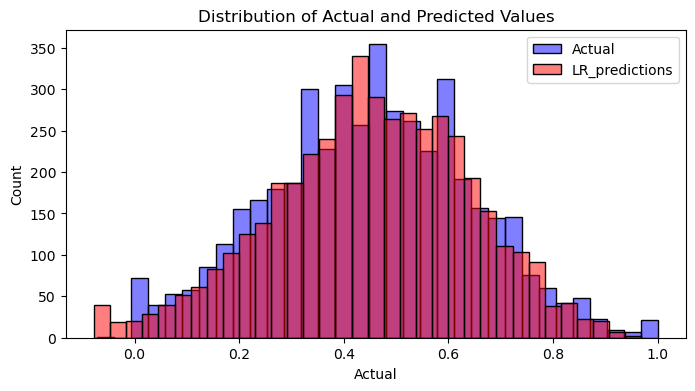

In [36]:
#Plotting the predicted over the actual
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(output_df['Actual'], color='blue', alpha=0.5, ax=ax, label='Actual')
sns.histplot(output_df['LR_predictions'], color='red', alpha=0.5, ax=ax, label='LR_predictions')
plt.title('Distribution of Actual and Predicted Values')
plt.legend()
plt.show()

### Using Random Forest Regression

In [37]:
%%time

#Import Necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

RF_regressor = RandomForestRegressor() #Initiate the algorithm
RF_regressor.fit(X_train, y_train) #Train the algorithm

y_test_pred = RF_regressor.predict(X_test)

RF_MAE = metrics.mean_absolute_error(y_test_pred, y_test)
RF_MSE = metrics.mean_squared_error(y_test_pred, y_test)
RF_RMSE = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
RF_R2 = metrics.r2_score(y_test_pred, y_test)

print('Mean Error = ', LR_MAE)
print('Mean Squared Error = ', LR_MSE)
print('Root Mean Squared Error = ', LR_RMSE)
print('R2 = ', R2)

Mean Error =  0.04088947898032476
Mean Squared Error =  0.0026403816307542243
Root Mean Squared Error =  0.05138464391969866
R2 =  0.9258823795980603
CPU times: total: 2.69 s
Wall time: 2.71 s


In [38]:
output_df['RF_predictions'] = y_test_pred #Creating a data frame of prediction output and comparing them with the actual
output_df.head()

,Actual,LR_predictions,RF_predictions
11203,0.21,0.293332,0.250357
14049,0.46,0.485682,0.429039
13815,0.40,0.385059,0.382872
6603,0.41,0.368109,0.360731
4202,0.56,0.620785,0.614293


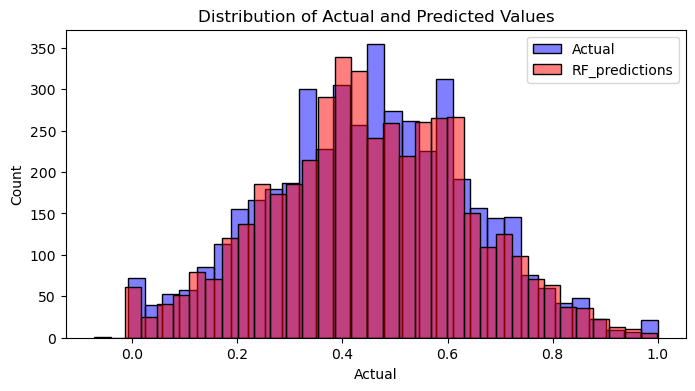

In [39]:
#Plotting the predicted over the actual
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(output_df['Actual'], color='blue', alpha=0.5, ax=ax, label='Actual')
sns.histplot(output_df['RF_predictions'], color='red', alpha=0.5, ax=ax, label='RF_predictions')
plt.title('Distribution of Actual and Predicted Values')
plt.legend()
plt.show()

### Using KNN Regression

In [40]:
%%time

#Import Necessary libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

KNN_regressor = KNeighborsRegressor() #Initiate the algorithm
KNN_regressor.fit(X_train, y_train) #Train the algorithm

y_test_pred = KNN_regressor.predict(X_test)

KNN_MAE = metrics.mean_absolute_error(y_test_pred, y_test)
KNN_MSE = metrics.mean_squared_error(y_test_pred, y_test)
KNN_RMSE = np.sqrt(metrics.mean_squared_error(y_test_pred, y_test))
KNN_R2 = metrics.r2_score(y_test_pred, y_test)

print('Mean Error = ', LR_MAE)
print('Mean Squared Error = ', LR_MSE)
print('Root Mean Squared Error = ', LR_RMSE)
print('R2 = ', R2)

Mean Error =  0.04088947898032476
Mean Squared Error =  0.0026403816307542243
Root Mean Squared Error =  0.05138464391969866
R2 =  0.9258823795980603
CPU times: total: 219 ms
Wall time: 213 ms


In [41]:
output_df['KNN_predictions'] = y_test_pred #Creating a data frame of prediction output and comparing them with the actual
output_df.head()

,Actual,LR_predictions,RF_predictions,KNN_predictions
11203,0.21,0.293332,0.250357,0.246443
14049,0.46,0.485682,0.429039,0.428000
13815,0.40,0.385059,0.382872,0.376000
6603,0.41,0.368109,0.360731,0.356000
4202,0.56,0.620785,0.614293,0.619152


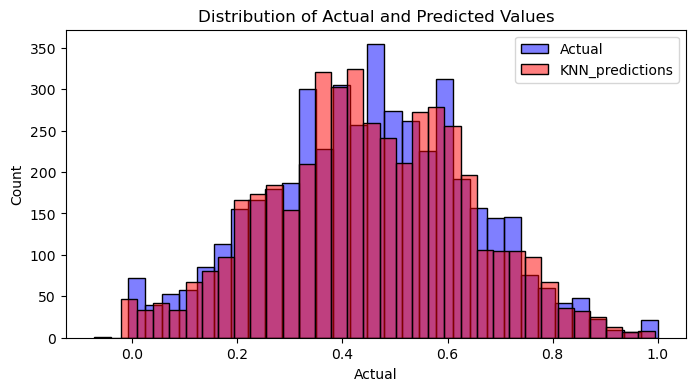

In [42]:
#Plotting the predicted over the actual
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(output_df['Actual'], color='blue', alpha=0.5, ax=ax, label='Actual')
sns.histplot(output_df['KNN_predictions'], color='red', alpha=0.5, ax=ax, label='KNN_predictions')
plt.title('Distribution of Actual and Predicted Values')
plt.legend()
plt.show()

### Comparing all models

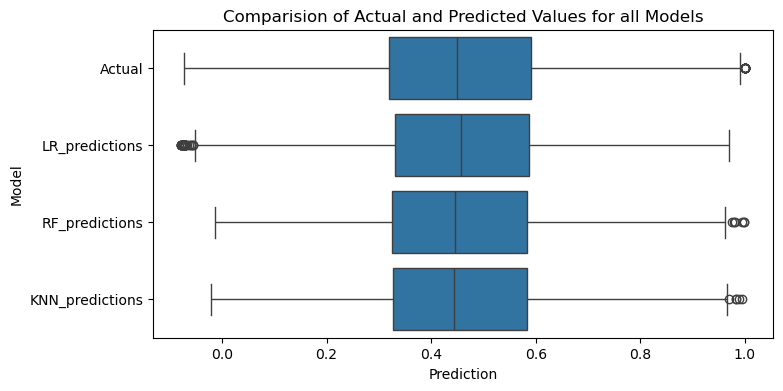

In [43]:
df_melted = pd.melt(output_df, var_name='Model', value_name='Prediction')

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='Prediction', y='Model', data=df_melted, ax=ax)

plt.title('Comparision of Actual and Predicted Values for all Models')

plt.show()

Each boxplot displays the distribution of predictions for each model relative to the actual values, showing key statistical features such as medians, interquartile ranges, and outliers. The actual values have a tighter distribution compared to the predictions, indicating that the models exhibit variability in their ability to approximate the actual data.

All three models show similar distributions with predictions closely aligned with the actual values. However, Linear Regression exhibits more outliers on the lower end, while Random Forest and KNN have slightly more outliers on the higher end. The spread of predictions across all models remains consistent, suggesting that all models capture the data pattern similarly.

In [44]:
#Comparing the MAE, MSE, RMSE and R2 values
mae_data = {
    'Algorithm/Model' : ['Linear Regression', 'Random Forest Regression', 'KNN Regression'],
    'Mean Absolute Error' : [LR_MAE, RF_MAE, KNN_MAE],
    'Mean Squared Error' : [LR_MSE, RF_MSE, KNN_MSE],
    'Root Mean Squared Error' : [LR_RMSE, RF_RMSE, KNN_RMSE],
    'R2' : [R2, RF_R2, KNN_R2]
}

models = pd.DataFrame(mae_data) # Create the DataFrame
models

,Algorithm/Model,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2
0,Linear Regression,0.040889,0.002640,0.051385,0.925882
1,Random Forest Regression,0.041314,0.002862,0.053500,0.920600
2,KNN Regression,0.042148,0.002834,0.053238,0.920954


The performance metrics table shows that Linear Regression achieved the lowest Mean Absolute Error (0.0409), Mean Squared Error (0.00264), and Root Mean Squared Error (0.0514) while also achieving the highest R² score (0.9259). This indicates that Linear Regression provides the most accurate predictions among the three models. Random Forest Regression and KNN Regression performed similarly with slightly higher errors and slightly lower R² scores (around 0.9205), making them marginally less accurate compared to Linear Regression.

## **Predicting burn rate on the test data set using Linear regression**

Choosing the Linear Regression as model of choice because it is the best performing model

Test data is in a different dataframe and imported. Prepare the test data to similar the prepared train data. Rename columns, encode categorical column, column and normalize numerical column

In [45]:
#Prepare the test dataset
#Remove spaces in column title and renaming column titles
col_names = [col.strip().lower().replace(' ', '_') for col in df_test.columns]
df_test.columns = col_names

#Rename column
df_test.rename(columns = {
    "date_of_joining": "start_date",
    "wfh_setup_available": "wfh", #WFH is work from home
    "resource_allocation": "work_hours",
    "mental_fatigue_score": "fatigue_score",}, inplace=True)

#Applying ordinal encoding on categorical columns
df_test_enc = df_test[['gender', 'company_type', 'wfh']] #Select categorical columns to encode

company_cat = ['Service', 'Product']
gender_cat = ['Male', 'Female']
wfh_cat = ['Yes', 'No']

# creating the ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories = [gender_cat, company_cat, wfh_cat],
                                handle_unknown='use_encoded_value',
                                unknown_value=-1,
                                )
                        

#applying the encoder
df_test_enc_cat = pd.DataFrame(encoder.fit_transform(df_test_enc),
                                columns=encoder.get_feature_names_out(),
                                index = df_test_enc.index)

#Importing the required library
from sklearn.preprocessing import MinMaxScaler

#Create MinMaxScaler instance
scaler = MinMaxScaler()

#Apply normalization
norm_test_df = pd.DataFrame(scaler.fit_transform(df_test[['designation', 'work_hours', 'fatigue_score']]))

#Rename the column
norm_test_df.columns = ['designation', 'work_hours', 'fatigue_score']

#Add normalized data to the data frame
df_norm_test = pd.concat([df_test_enc_cat, norm_test_df], axis=1)

#df_norm_test.drop(['designation', 'work_hours', 'fatigue_score'], axis=1, inplace=True)

df_norm_test.head()

,gender,company_type,wfh,designation,work_hours,fatigue_score
0,1.0,0.0,1.0,0.4,0.444444,0.77
1,1.0,1.0,0.0,0.2,0.111111,0.52
2,0.0,1.0,0.0,0.2,0.222222,0.59
3,1.0,0.0,1.0,0.6,0.555556,0.46
4,1.0,1.0,1.0,0.4,0.444444,0.64


In [46]:
#Assign the test data
X_test_pred = df_norm_test
X_test_pred.head()

,gender,company_type,wfh,designation,work_hours,fatigue_score
0,1.0,0.0,1.0,0.4,0.444444,0.77
1,1.0,1.0,0.0,0.2,0.111111,0.52
2,0.0,1.0,0.0,0.2,0.222222,0.59
3,1.0,0.0,1.0,0.6,0.555556,0.46
4,1.0,1.0,1.0,0.4,0.444444,0.64


In [47]:
#Predicting the burn rate using Linear regression
#Import Necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn import metrics

LR_regressor = LinearRegression() #Initiate the algorithm
LR_regressor.fit(X_train, y_train) #Train the algorithm

y_test_pred = LR_regressor.predict(X_test_pred) #Predicting burn_rate

df_test_pred = pd.DataFrame({'burn_rate': y_test_pred})
df_test_pred.head()

,burn_rate
0,0.651691
1,0.348199
2,0.439527
3,0.426950
4,0.545734


In [48]:
pred_burn_rate = pd.concat([df_test, df_test_pred], axis=1) #Adding the predicted burn rate column to test dataframe
pred_burn_rate.head()

,employee_id,start_date,gender,company_type,wfh,designation,work_hours,fatigue_score,burn_rate
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7,0.651691
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2,0.348199
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9,0.439527
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6,0.426950
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4,0.545734


In [49]:
#Convert start date to date format
pred_burn_rate['start_date'] = pd.to_datetime(pred_burn_rate['start_date'])

today = pd.Timestamp.today().normalize() #Get today's date

#Adding a new feature to the test dataframe
pred_burn_rate['tenure'] = today - pred_burn_rate['start_date']
pred_burn_rate.head()

,employee_id,start_date,gender,company_type,wfh,designation,work_hours,fatigue_score,burn_rate,tenure
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7,0.651691,6174 days
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2,0.348199,6292 days
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9,0.439527,6201 days
3,fffe3100370039003200,2008-02-07,Female,Service,No,3.0,6.0,4.6,0.426950,6481 days
4,fffe32003600390036003700,2008-07-17,Female,Product,No,2.0,5.0,6.4,0.545734,6320 days


To move on with the next part of this case study, we would save some relevant files like the scaler, encoder and model to be used to create our Stremlit app.

In [50]:
#importing required library
import joblib

# Save the trained model
joblib.dump(LR_regressor, 'Streamlit/linear_regressor.pkl')

# Save the scaler
joblib.dump(scaler, 'Streamlit/scaler.pkl')

# Save the encoder
joblib.dump(encoder, 'Streamlit/encoder.pkl')

print("Model, scaler, and encoder saved successfully!")

Model, scaler, and encoder saved successfully!


## **Phase 5: Insights, Recommendations and Solution Development**

## **Burnout Rate Analysis Report**
**1. Demographic and Company Characteristics**

**Gender Distribution:** The dataset consists of 52.3% women and 47.7% men, indicating a slightly higher representation of women.

**Company Type:** The majority of workers are employed in service companies (65.2%), while 34.8% are in product companies.

**Work from Home Availability:** 54% of employees have the option of working from home, whereas 46% do not.

**2. Work and Fatigue Statistics**

**Average Work Hours:** Employees work an average of 4.48 hours per day, with a standard deviation of 2 hours.

**Fatigue Score:** The mean fatigue score is 5.7, with a standard deviation of approximately 2.

**Burn Rate:** The mean burn rate is 0.45 across the dataset.

**3. Temporal Trends (2018)**

Line plot analysis shows that:

**June** recorded the highest burn rate among workers.

**June** also had the highest work hours reported.

**June** further recorded the highest fatigue score, suggesting a strong seasonal or workload-related impact.

**4. Relationships and Correlations**

**Scatter Plot Analysis:** Burn rate is strongly associated with designation, work hours, and fatigue score.

**Correlation Heatmap:** Fatigue score, work hours, and designation show strong correlations with burn rate.

Fatigue score has the highest impact (up to 95%) on burn rate.

**5. Box Plot Analysis**

**Gender vs. Burn Rate:** Males show a slightly higher burn rate compared to females.

**Company Type vs. Burn Rate:** No significant impact of company type on burn rate.

**Work from Home vs. Burn Rate:** Employees without work-from-home options experience higher burnout rates than those with remote work opportunities.

**6. Statistical Testing**

**ANOVA Test:** Confirms that gender and working from home have a statistically significant impact on burn rate.

**7. Predictive Modeling and Evaluation**

**Boxplot of Model Predictions:**

Actual values have a tighter distribution than model predictions, suggesting variability in model performance.

Linear Regression showed more outliers on the lower end.

Random Forest and KNN had slightly more outliers on the higher end.

All three models captured the general data pattern similarly.

**Performance Metrics:**

Linear Regression outperformed other models with the lowest errors and the highest R² score:

Mean Absolute Error (MAE): 0.0409

Mean Squared Error (MSE): 0.00264

Root Mean Squared Error (RMSE): 0.0514

R² Score: 0.9259

Random Forest Regression and KNN Regression performed comparably but with slightly higher errors and marginally lower R² scores (~0.9205).

**8. Conclusion**

The analysis reveals that fatigue score, work hours, and designation are the strongest predictors of burnout rate. Gender and work-from-home availability also significantly influence burnout, while company type has no measurable impact. Among predictive models, Linear Regression proved to be the most effective, providing the highest accuracy and reliability in estimating burnout rates.

## **Recommendations**

**1. Optimize work hours:** introduce flexible scheduling, workload rotation, and limit excessive overtime to avoid spikes in burnout.

**2. Support Remote Work Options:** Expanding remote or hybrid work policies can help reduce burnout and improve work-life balance.

**3. Improve designation management:** organize mentorship programs, delegation of responsibilities, and leadership support training.